In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import reg_plot
from nctpy.plotting import add_module_lines
from nctpy.utils import convert_states_str2int

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data/mouse'
outdir = '/home/lindenmp/research_projects/nct_xr/data'

In [3]:
A_file = os.path.join(indir, 'normalized_connection_strength_ipsi.csv')
A = np.loadtxt(os.path.join(indir, A_file), dtype=float, delimiter=",", encoding="utf-8-sig")
A = A.T  # set rows=tagets and columns=sources. That is, Aij = edge from node j to node i
print(A.shape)
print(np.all(np.round(A, 4) == np.round(A.T, 4)))

(461, 461)
False


In [4]:
# load region class
region_class = pd.read_csv(os.path.join(indir, "region_class.csv"))

# retain isocortex
idx = region_class["Isocortex"] == 1
# subset A
A = A[region_class[idx].index, :][:, region_class[idx].index]
n_nodes = A.shape[0]
print(A.shape)

# get density including self connections
density = np.count_nonzero(A) / A.shape[0] ** 2
print(density)

# subset region_class
region_class = region_class[idx]

# sort on Isocortex_modules
region_class.reset_index(inplace=True, drop=True)
region_class["sort_idx"] = region_class.index
region_class.sort_values("Isocortex_modules", inplace=True)
region_class.reset_index(inplace=True, drop=True)
# sort A to match
A = A[region_class.sort_idx, :][:, region_class.sort_idx]

print(region_class)

(43, 43)
1.0
     Region  Class  Isocortex Isocortex_modules  sort_idx
0      AUDv      0          1          Auditory        16
1     AUDpo      0          1          Auditory        15
2      AUDp      0          1          Auditory        14
3      AUDd      0          1          Auditory        13
4       ECT     12          1           Lateral        42
5      PERI     12          1           Lateral        41
6        GU     12          1           Lateral        11
7       AId      0          1           Lateral        32
8      VISC     12          1           Lateral        12
9       AIv      0          1           Lateral        34
10      TEa     12          1           Lateral        40
11      AIp      0          1           Lateral        33
12   RSPagl      0          1            Medial        35
13     RSPd      0          1            Medial        36
14     RSPv      0          1            Medial        37
15     VISa      0          1            Medial        38
1

### Plot adjacency

In [5]:
A[np.eye(A.shape[0]) == 1] = 0

['Auditory' 'Lateral' 'Medial' 'PFC' 'Somatomotor' 'Visual']


/tmp/ipykernel_3081404/1940861912.py:2: RuntimeWarning: divide by zero encountered in log
  A_log = np.log(A)


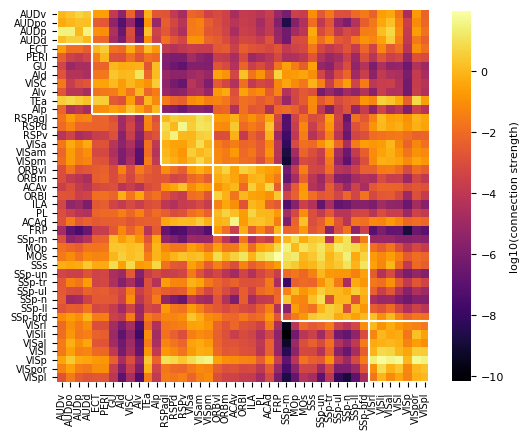

In [6]:
# plot A matrix
A_log = np.log(A)
A_log[np.eye(A_log.shape[0]) == 1] = 0
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    A_log,
    ax=ax,
    square=True,
    cmap="inferno",
    xticklabels=region_class.Region,
    yticklabels=region_class.Region,
    cbar_kws={"label": "log10(connection strength)", "shrink": 0.8},
)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=7)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=7)
add_module_lines(region_class["Isocortex_modules"], ax)
f.savefig(
    os.path.join(outdir, "mouse_connectome.png"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()

In [7]:
# load t1/t2 from Fulcher PNAS
in_file = os.path.join(indir, 'T1T2Table.csv')
mouse_myelin = pd.read_csv(in_file, index_col=0)
mouse_myelin.index = mouse_myelin.index - 1

mouse_myelin.head()

,id,acronym,name,T1,T2,T1T2,OLDT1T2,cellCount,voxelCountCCF
index,,,,,,,,,
0,22,PTLp,Posterior parietal association areas,10621.646740,9681.412298,1.097117,1.097117,504703,89466
1,39,ACAd,"Anterior cingulate area, dorsal part",10066.695460,11177.449280,0.900625,0.900625,349622,397621
2,44,ILA,Infralimbic area,8505.800127,13510.920000,0.629550,0.629550,205617,50601
3,48,ACAv,"Anterior cingulate area, ventral part",9137.063759,13148.290730,0.694924,0.694924,337285,155849
4,104,AId,"Agranular insular area, dorsal part",9394.407071,10897.900910,0.862038,0.862038,218853,50745


In [8]:
# append t1/t2 to region_class
region_class['T1T2'] = np.nan
for idx in region_class.index:
    if region_class.loc[idx, 'Region'] in list(mouse_myelin['acronym']):  # if our region is in the mouse myelin matrix
        loc_idx = np.where(mouse_myelin['acronym'] == region_class.loc[idx, 'Region'])[0][0]  # find the mitching region idx in the mouse myelin data
        region_class.loc[idx, 'T1T2'] = mouse_myelin.loc[loc_idx, 'T1T2'].copy()  # copy myelin data to appropriate spot on our dataframe
        
region_class.head()

,Region,Class,Isocortex,Isocortex_modules,sort_idx,T1T2
0,AUDv,0,1,Auditory,16,0.905460
1,AUDpo,0,1,Auditory,15,1.014451
2,AUDp,0,1,Auditory,14,1.043728
3,AUDd,0,1,Auditory,13,1.153094
4,ECT,12,1,Lateral,42,0.787750


In [9]:
# load gene data from Fulcher PNAS
in_file = os.path.join(indir, 'geneInfo.csv')
mouse_gene_info = pd.read_csv(in_file)
in_file = os.path.join(indir, 'structInfo.csv')
mouse_struct_info = pd.read_csv(in_file)

in_file = os.path.join(indir, 'PCAResults_bayesian_brainExpressed_scaledSigmoid_benCombo.mat')
mouse_gene_data = sp.io.loadmat(in_file)
# mouse_gene_data = mouse_gene_data['geneDataZ']
mouse_gene_data = mouse_gene_data['normalizedGeneData']

mouse_struct_info.head()

/home/lindenmp/anaconda3/envs/nct_xr/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,acronym,color_hex_triplet,id,name,divisionLabel
0,SSp-ll,188064,337,"Primary somatosensory area, lower limb",Isocortex
1,VISpm,08858C,533,posteromedial visual area,Isocortex
2,ECT,0D9F91,895,Ectorhinal area,Isocortex
3,AUDd,019399,1011,Dorsal auditory area,Isocortex
4,SSp-bfd,188064,329,"Primary somatosensory area, barrel field",Isocortex


In [10]:
# append gene data to region_class
# gene_list = ['Pvalb', 'Grin3a', 'Sst']
gene_list = ['Pvalb', 'Sst']

for gene in gene_list:
    region_class[gene] = np.nan

    loc_idx_gene = np.where(mouse_gene_info['acronym'] == gene)[0][0]  # find gene location from 1055 genes using string search
    for idx in region_class.index:
        if region_class.loc[idx, 'Region'] in list(mouse_struct_info['acronym']):  # if our region is in the mouse gene matrix
            loc_idx = np.where(mouse_struct_info['acronym'] == region_class.loc[idx, 'Region'])[0][0]  # find the mitching region idx in the mouse gene data
            region_class.loc[idx, gene] = mouse_gene_data[loc_idx, loc_idx_gene]  # copy gene data to appropriate spot on our dataframe
        
region_class.head()

,Region,Class,Isocortex,Isocortex_modules,sort_idx,T1T2,Pvalb,Sst
0,AUDv,0,1,Auditory,16,0.905460,0.145150,1.000000
1,AUDpo,0,1,Auditory,15,1.014451,0.468842,0.877496
2,AUDp,0,1,Auditory,14,1.043728,0.250070,0.893964
3,AUDd,0,1,Auditory,13,1.153094,0.597272,0.822021
4,ECT,12,1,Lateral,42,0.787750,0.579552,0.670112


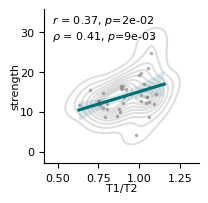

In [11]:
f, ax = plt.subplots(1, 1, figsize=(2, 2))
nan_mask = np.isnan(region_class['T1T2'])
reg_plot(region_class['T1T2'][~nan_mask], A.sum(axis=0)[~nan_mask], xlabel='T1/T2', ylabel='strength', ax=ax, annotate='both')

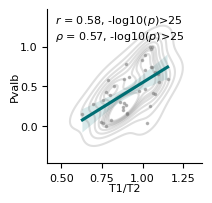

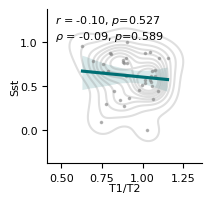

In [12]:
for gene in gene_list:
    f, ax = plt.subplots(1, 1, figsize=(2, 2))
    reg_plot(region_class['T1T2'][~nan_mask], region_class[gene][~nan_mask], xlabel='T1/T2', ylabel=gene, ax=ax, annotate='both')

### Get states

In [13]:
print(region_class)

     Region  Class  Isocortex Isocortex_modules  sort_idx      T1T2     Pvalb  \
0      AUDv      0          1          Auditory        16  0.905460  0.145150   
1     AUDpo      0          1          Auditory        15  1.014451  0.468842   
2      AUDp      0          1          Auditory        14  1.043728  0.250070   
3      AUDd      0          1          Auditory        13  1.153094  0.597272   
4       ECT     12          1           Lateral        42  0.787750  0.579552   
5      PERI     12          1           Lateral        41  0.879893  0.202851   
6        GU     12          1           Lateral        11  0.877371  0.244098   
7       AId      0          1           Lateral        32  0.862038  0.301833   
8      VISC     12          1           Lateral        12  0.902017  0.158101   
9       AIv      0          1           Lateral        34  0.805014  0.069891   
10      TEa     12          1           Lateral        40  0.800036  0.392993   
11      AIp      0          

In [14]:
# get system labels
# system_labels = list(region_class["system_labels"])
system_labels = list(region_class["Isocortex_modules"])

In [15]:
print(len(system_labels))
print(system_labels[:20])

43
['Auditory', 'Auditory', 'Auditory', 'Auditory', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Medial', 'Medial', 'Medial', 'Medial', 'Medial', 'Medial', 'PFC', 'PFC']


In [16]:
# use list of system names to create states
states, state_labels = convert_states_str2int(system_labels)
states.shape

(43,)

In [17]:
n_states = len(state_labels)
centroids = np.zeros((n_states, n_nodes))
for i in np.arange(n_states):
    centroids[i, :] = states == i
centroids.shape

(6, 43)

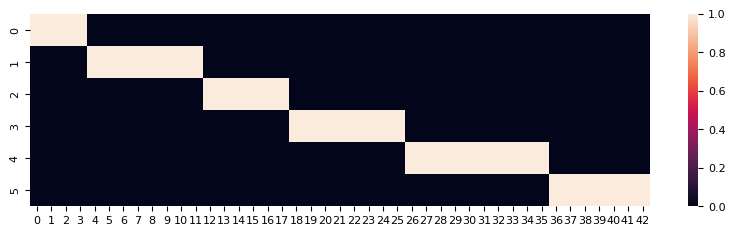

In [18]:
f, ax = plt.subplots(figsize=(10, 2.5))
sns.heatmap(centroids, ax=ax, square=False)
plt.show()

## Save data

In [ ]:
file_str = 'mouse_cortex_Am'
np.save(os.path.join(outdir, file_str), A)

my_dict = dict()
my_dict['centroids'] = centroids
file_str = 'mouse_cortex_brain_states'
np.save(os.path.join(outdir, file_str), my_dict)

file_str = 'mouse_cortex_myelin'
np.save(os.path.join(outdir, file_str), region_class['T1T2'])
file_str = 'mouse_cortex_region_data.csv'
region_class.to_csv(os.path.join(outdir, file_str))